<a href="https://colab.research.google.com/github/SebastianKropp/DisasterDetectionModel/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 144 Spring 2023 Project

Transformer model for disaster tweet detection.

Steps:

1. Preprocessing: Preprocess the text by tokenizing and converting the text to numerical representations using tokenizer from pretrained model.

2. Model Implementation: Implement a BERT model for detecting disaster tweets.

3. Model Evaluation: Train the model on the preprocessed dataset and evaluate its performance using accuracy, precision, recall, and F1-score. Experiment with different hyperparameters such as learning rate, batch size, and number of epochs to optimize the model's performance.

4. (Optional) Model Interpretation: Analyze the model's predictions by examining the most important features or words that contribute to a disaster or non-disaster tweet. (Optional: Visualize the results using techniques such as word clouds or attention maps).

Datasets: 

- Kaggle dataset: https://www.kaggle.com/competitions/nlp-getting-started/data
- Additional: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets?select=tweets.csv

## Dependencies and Imports

In [ ]:
!pip install transformers
!pip install sentencepiece sacremoses importlib_metadata
!pip install datasets

In [2]:
import pandas as pd
import random
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from datasets import load_dataset
import math
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preprocessing
Preprocess the text by tokenizing and converting the text to numerical representations.

### Load Dataset

In [127]:
# Load the dataset from CSV
dataset_path = 'preprocessed_train.csv'  # Replace with the path to your dataset
dataset = pd.read_csv(dataset_path)

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(dataset['text'], dataset['target'], test_size=0.2, random_state=42)

train_neutral, test_neutral = train_test_split(dataset['neutral'], test_size=0.2, random_state=42)
train_positive, test_positive = train_test_split(dataset['positive'], test_size=0.2, random_state=42)
train_negative, test_negative = train_test_split(dataset['negative'], test_size=0.2, random_state=42)
train_sarcasm, test_sarcasm = train_test_split(dataset['sarcastic'], test_size=0.2, random_state=42)

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Tokenization

In [128]:
def preprocess(texts, sarcasm, neutral, positive, negative):
  texts = texts.tolist() if isinstance(texts, pd.Series) else texts  # Convert to list if needed
  sarcasm = sarcasm.tolist() if isinstance(sarcasm, pd.Series) else sarcasm
  neutral = neutral.tolist() if isinstance(neutral, pd.Series) else neutral
  positive = positive.tolist() if isinstance(positive, pd.Series) else positive
  negative = negative.tolist() if isinstance(negative, pd.Series) else negative

  encoded_inputs = tokenizer(
    texts,
    padding='longest',
    truncation=True,
    max_length=512,
    return_tensors='pt',
    add_special_tokens=True
  )
  input_ids = encoded_inputs['input_ids'].to(device)
  attention_masks = encoded_inputs['attention_mask'].to(device)
  sarcasm_probs = torch.tensor(sarcasm).to(device)
  neutral_probs = torch.tensor(neutral).to(device)
  positive_probs = torch.tensor(positive).to(device)
  negative_probs = torch.tensor(negative).to(device)

  return input_ids, attention_masks, sarcasm_probs, neutral_probs, positive_probs, negative_probs

In [ ]:
# Test preprocess()
test = train_texts[:2]
input_ids, attention_masks = preprocess(test)

# Print the first example
print("Text:", test.iloc[0])
print("Tokenized input:", tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
print("Input IDs:", input_ids[0])
print("Attention Mask:", attention_masks[0])

### Build DataLoaders

In [129]:
# ----- Build train dataset -----

# Preprocess the text data
#train_input_ids, train_attention_masks = preprocess(train_texts)
train_input_ids, train_attention_masks, train_sarcasm_probs, train_neutral_probs, train_positive_probs, train_negative_probs = preprocess(train_texts, train_sarcasm, train_neutral, train_positive, train_negative)

# Convert train_labels to a list, then to a tensor
train_labels = torch.tensor(train_labels.tolist()).to(device)

# Build train dataset
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# ------ Build test dataset -----

# Preprocess the text data
#test_input_ids, test_attention_masks = preprocess(test_texts)
test_input_ids, test_attention_masks, test_sarcasm_probs, test_neutral_probs, test_positive_probs, test_negative_probs = preprocess(test_texts, test_sarcasm, test_neutral, test_positive, test_negative)

# Convert train_labels to a list, then to a tensor
test_labels = torch.tensor(test_labels.tolist()).to(device)

# Build test dataset
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [130]:
# Define batch size
batch_size = 128

# Build DataLoaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Implementation
Implement model using a pre-trained model.

In [144]:
%%capture captured_output
# Number of labels
num_labels = 2

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Download model and configuration from S3 and cache.
config = AutoConfig.from_pretrained(model_name)
last_state_dim = config.hidden_size

# Create additional embeddings
sarcasm_embedding_dim = 8
sentiment_embedding_dim = 16

model.sarcasm_embedding = nn.Linear(1, sarcasm_embedding_dim)
model.sentiment_embedding = nn.Linear(3, sentiment_embedding_dim)
model.classifier = torch.nn.Linear(last_state_dim, num_labels) # Replace the pre-trained head with a new one.

model.to(device)
del captured_output

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

## Evaluation
Train the model on the preprocessed dataset and evaluate its performance using accuracy, precision, recall, and F1-score. Experiment with different hyperparameters such as learning rate, batch size, and number of epochs to optimize the model's performance.

### Train

In [101]:
def train_model(model):
  model.train()
  losses = []  # List to store the loss after each epoch
  accuracies = []
  val_accuracies = []
  best_val_accuracy = -1  # Initialize the best validation accuracy
  early_stopping_counter = 0  # Counter for early stopping
    
  for epoch in range(epochs):
      running_loss = 0.0
        
      for batch in trainloader:
          input_ids, attention_masks, labels = batch
          input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)
            
          optimizer.zero_grad()
            
          # Forward pass
          outputs = model(input_ids, attention_mask=attention_masks)
          logits = outputs.logits.to(device)
          loss = criterion(logits, labels)
            
          # Backward pass and optimization
          loss.backward()
          #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

          optimizer.step()
          #scheduler.step()
          losses.append(loss.detach().cpu().numpy())

          # Calculate accuracy
          _, predicted_labels = torch.max(logits, dim=1)
          batch_accuracy = (predicted_labels == labels).sum().item() / labels.size(0)
          accuracies.append(batch_accuracy)

          # Uncomment to calculate validation accuracy (takes more time)
          val_accuracy, _, _, _, _ = evaluate_model(model, valloader, False)
          val_accuracies.append(val_accuracy)

      # Check if the current validation accuracy is better than the previous best
      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          early_stopping_counter = 0  # Reset the counter
      else:
          early_stopping_counter += 1  # Increment the counter

      print('Train Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.4f}\tValidation Accuracy: {:.4f}'.format(
        epoch, loss.item(), batch_accuracy, val_accuracy))
      #print('Train Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.4f}'.format(
      #  epoch, loss.item(), batch_accuracy))

      # Check if early stopping criterion is met
      if early_stopping_counter >= patience:
        print("Early stopping triggered. No improvement in validation accuracy for {} epochs.".format(patience))
        break

  return losses, accuracies, val_accuracies

In [145]:
# Define learning rate and number of epochs
learning_rate = 1e-5
epochs = 50
patience = 3

# Define the optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80%
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~81% accuracy
#optimizer = optim.Adam(model.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80% accuracy

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

# Define the scheduler to adjust learning rate
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(trainloader) * epochs)

In [146]:
# Train model
losses, accuracies, val_accuracies = train_model(model)

Train Epoch: 0	Loss: 0.648262	Train Accuracy: 0.8333	Validation Accuracy: 0.7118
Train Epoch: 1	Loss: 0.745058	Train Accuracy: 0.6667	Validation Accuracy: 0.7381
Train Epoch: 2	Loss: 0.486048	Train Accuracy: 0.8333	Validation Accuracy: 0.7479
Train Epoch: 3	Loss: 0.437673	Train Accuracy: 1.0000	Validation Accuracy: 0.7578
Train Epoch: 4	Loss: 0.617486	Train Accuracy: 0.6667	Validation Accuracy: 0.7660
Train Epoch: 5	Loss: 0.838190	Train Accuracy: 0.3333	Validation Accuracy: 0.7685
Train Epoch: 6	Loss: 0.374194	Train Accuracy: 1.0000	Validation Accuracy: 0.7775
Train Epoch: 7	Loss: 0.338632	Train Accuracy: 0.8333	Validation Accuracy: 0.7857
Train Epoch: 8	Loss: 0.233623	Train Accuracy: 1.0000	Validation Accuracy: 0.7898
Train Epoch: 9	Loss: 0.430680	Train Accuracy: 0.8333	Validation Accuracy: 0.7915
Train Epoch: 10	Loss: 0.207039	Train Accuracy: 0.8333	Validation Accuracy: 0.7915
Train Epoch: 11	Loss: 0.593053	Train Accuracy: 0.6667	Validation Accuracy: 0.7956
Train Epoch: 12	Loss: 0.15

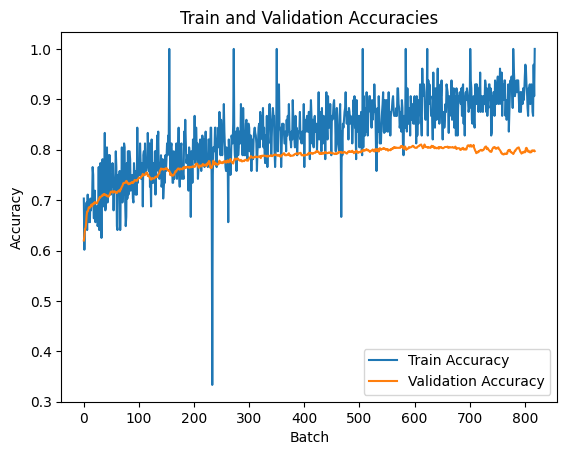

In [147]:
# Compare train and validation accuracy during training
plt.plot(accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(0, len(losses)), losses)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(0, len(accuracies)), accuracies)

### Evaluate

In [14]:
def evaluate_model(model, dataloader, is_test=True):
    model.eval()
    predictions = []
    true_labels = []
    predicted_probs = []
    input_ids_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits.to(device)

            _, predicted_labels = torch.max(logits, dim=1)
            predicted_prob = torch.softmax(logits, dim=1)

            predictions.extend(predicted_labels.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
            predicted_probs.extend(predicted_prob.cpu().tolist())  # Assuming class 1 is the positive class
            input_ids_list.extend(input_ids.cpu().tolist())

    predicted_probs = np.array(predicted_probs)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)

    if is_test:
      print("Evaluation on test set:")
      precision = precision_score(true_labels, predictions, average='macro')
      recall = recall_score(true_labels, predictions, average='macro')
      f1 = f1_score(true_labels, predictions, average='macro')
      return accuracy, precision, recall, f1, true_labels, predictions, predicted_probs, input_ids_list

    else:
        return accuracy, true_labels, predictions, predicted_probs, input_ids_list

In [148]:
# Evaluate model
accuracy, precision, recall, f1, true_labels, predictions, predicted_probs, input_ids_list = evaluate_model(model, testloader)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluation on test set:
Accuracy: 0.8062
Precision: 0.8029
Recall: 0.8003
F1 Score: 0.8014


In [ ]:
def find_most_significant_words(input_ids_list, predicted_probs):
    token_scores = {}

    # Aggregate the predicted probabilities for each token across examples
    for example_probs in predicted_probs:
        for token_index, prob_positive_class in enumerate(example_probs):
            if token_index not in token_scores:
                token_scores[token_index] = prob_positive_class
            else:
                token_scores[token_index] += prob_positive_class

    # Sort the token scores in descending order
    sorted_scores = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)

    # Get the top 10 most significant words
    top_10_tokens = [token_index for token_index, _ in sorted_scores[:10]]
    top_10_words = [tokenizer.convert_ids_to_tokens(input_ids[token_index]) for token_index in top_10_tokens]

    return top_10_words

In [ ]:
top_words = find_most_significant_words(input_ids_list, predicted_probs)
print(top_words)

[['[CLS]', '@', 'organic', '##ally', '##rud', '##e', '@', '1', '##rock', '##star', '##6', '##2', '#', 'wish', 'matt', '##ingly', '&', 'amp', ';', 'bun', '##dy', '&', 'amp', ';', 'mc', '##g', '##wire', 'were', 'standing', 'on', 'it', 'when', 'it', 'collapsed', '!', '[SEP]', '[PAD]'], ['[CLS]', 'courageous', 'and', 'honest', 'analysis', 'of', 'need', 'to', 'use', 'atomic', 'bomb', 'in', '1945', '.', '#', 'hiroshima', '##70', 'japanese', 'military', 'refused', 'surrender', '.', 'https', ':', '/', '/', 't', '.', 'co', '/', 'v', '##hm', '##ty', '##tp', '##t', '##gr', '[SEP]']]


## Visualizations

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns

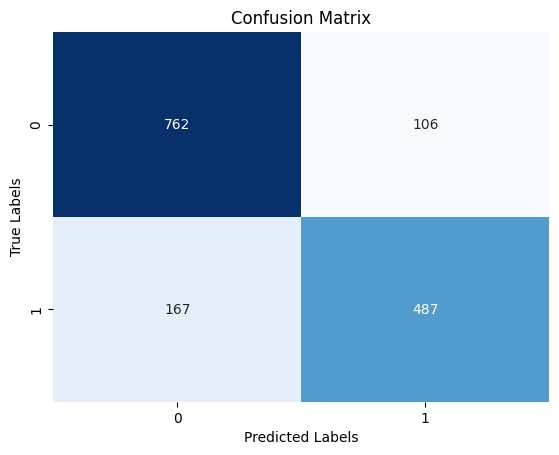

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

    # Set axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

plot_confusion_matrix(true_labels, predictions)

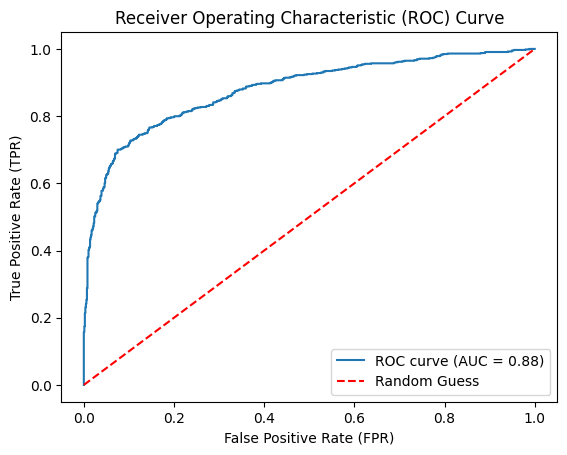

In [ ]:
def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs[:, 1])
    auc = roc_auc_score(true_labels, predicted_probs[:, 1])

    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, predicted_probs)

### Predict Disaster or Not

Use trained model to predict if a tweet is about a disaster or not.

In [ ]:
def preprocess_TA(text):
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
  return inputs['input_ids'].to(device), inputs['attention_mask'].to(device)

def predict_disaster_TA(texts):
  model.eval() # Set the model to evaluation mode
  input_ids, attention_mask = preprocess_TA(texts)

  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask) # Get the model outputs
    logits = outputs.logits # Get the logits from the model outputs
    probabilities = F.softmax(logits, dim=1)
    disasters = torch.argmax(probabilities, dim=1).squeeze()

  return disasters, probabilities

In [ ]:
# Call the predict_sentiment_TA function
text = "Was in NYC last week!"
disaster, probabilities = predict_disaster_TA(text)

print(f"Disaster: {disaster}")
print(f"Probabilities: {probabilities}")

Disaster: 0
Probabilities: tensor([[0.9179, 0.0821]], device='cuda:0')
